# Imports and Setup

In [1]:
import os
import sys
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import drive
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

BATCH_SIZE = 16
IMAGE_SIZE = (128, 128)
EPOCHS = 10


In [2]:
drive.mount('/content/drive', force_remount=True)

dataset_dir = "/content/drive/MyDrive/SkinAI/melanoma_cancer_dataset"

if dataset_dir not in sys.path:
  sys.path.insert(0, dataset_dir)

Mounted at /content/drive


# Visualizing some images from the Dataset

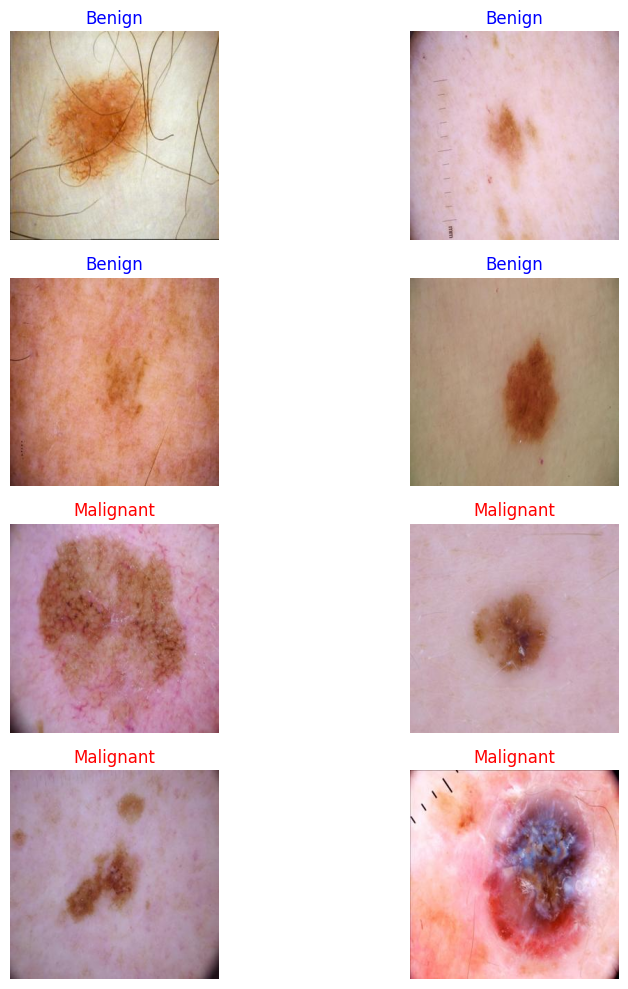

In [3]:
data = {"train": {"benign": [], "malignant": []}, "test": {"benign": [], "malignant": []}}

for folder in ["train", "test"]:
    for category in ["benign", "malignant"]:
        category_path = os.path.join(dataset_dir, folder, category)
        file_paths = glob(os.path.join(category_path, "*.jpg"))
        data[folder][category].extend(file_paths)

plt.figure(figsize=(10, 10))

for i, filepath in enumerate(data["train"]["benign"][:4]):
    image = Image.open(filepath)
    plt.subplot(4, 2, i + 1)
    plt.imshow(image)
    plt.title("Benign", color="blue", fontsize=12)
    plt.axis("off")

for i, filepath in enumerate(data["train"]["malignant"][:4]):
    image = Image.open(filepath)
    plt.subplot(4, 2, i + 5)
    plt.imshow(image)
    plt.title("Malignant", color="red", fontsize=12)
    plt.axis("off")

plt.tight_layout()
plt.show()


# Counting the number of files by category

In [4]:
image_counts = {"train": {"benign": 0, "malignant": 0}, "test": {"benign": 0, "malignant": 0}}

for folder in ["train", "test"]:
    for category in ["benign", "malignant"]:
        category_path = os.path.join(dataset_dir, folder, category)
        if os.path.exists(category_path):
            num_images = len(glob(os.path.join(category_path, "*.jpg")))
            image_counts[folder][category] = num_images
            print(f"{folder}/{category}: {num_images} images")

train/benign: 5000 images
train/malignant: 4605 images
test/benign: 500 images
test/malignant: 500 images


# Load and preprocess the data

In [5]:
train_files = (
    data["train"]["benign"] +
    data["train"]["malignant"]
)
train_labels = (
    [0] * len(data["train"]["benign"]) +
    [1] * len(data["train"]["malignant"])
)

val_files = (
    data["test"]["benign"] +
    data["test"]["malignant"]
)
val_labels = (
    [0] * len(data["test"]["benign"]) +
    [1] * len(data["test"]["malignant"])
)

file_ds_train = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
file_ds_val   = tf.data.Dataset.from_tensor_slices((val_files, val_labels))


In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def augment(img, label):
    img = data_augmentation(img, training=True)
    return img, label

train_ds = (
    file_ds_train
    .shuffle(2000)
    .map(load_image, num_parallel_calls=AUTOTUNE)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    file_ds_val
    .map(load_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


In [8]:
y_train = np.array(
    [0] * len(data["train"]["benign"]) +
    [1] * len(data["train"]["malignant"])
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)

class_weight = {
    0: class_weights[0],
    1: class_weights[1]
}

print("Class weights:", class_weight)

Class weights: {0: np.float64(0.9605), 1: np.float64(1.0428881650380022)}


# Build a Convolutional Neural Network Model

In [9]:
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, 3, activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(128, 3, activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(),
    GlobalAveragePooling2D(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()




Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,273 (368.25 KB)

 Trainable params: 93,825 (366.50 KB)

 Non-trainable params: 448 (1.75 KB)

# Training

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
import time

checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/SkinAI/models/skinai_best.keras",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

training = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[
        TensorBoard(log_dir=f"logs/run_{int(time.time())}"),
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
        checkpoint
    ]
)

model.save("/content/drive/MyDrive/SkinAI/models/skinai_model_final.keras")

Epoch 1/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.9101 - loss: 0.2685
Epoch 1: val_loss improved from inf to 0.37550, saving model to /content/drive/MyDrive/SkinAI/models/skinai_best.keras
601/601 ━━━━━━━━━━━━━━━━━━━━ 526s 860ms/step - accuracy: 0.9101 - loss: 0.2686 - val_accuracy: 0.8580 - val_loss: 0.3755 - learning_rate: 1.0000e-04
Epoch 2/10
598/601 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7642 - loss: 0.5701
Epoch 2: val_loss did not improve from 0.37550
601/601 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.7647 - loss: 0.5689 - val_accuracy: 0.8240 - val_loss: 0.4063 - learning_rate: 1.0000e-04
Epoch 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7504 - loss: 0.5907
Epoch 3: val_loss did not improve from 0.37550
601/601 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.7505 - loss: 0.5904 - val_accuracy: 0.8320 - val_loss: 0.3846 - learning_rate: 1.0000e-04
Epoch 4/10
598/601 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6130 - loss: 0.

In [11]:
reloaded = tf.keras.models.load_model("/content/drive/MyDrive/SkinAI/models/skinai_model_final.keras")
x_batch, y_batch = next(iter(val_ds))
p1 = model.predict(x_batch)
p2 = reloaded.predict(x_batch)
print("max abs diff:", np.max(np.abs(p1 - p2)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
max abs diff: 0.0


# Plot Performance

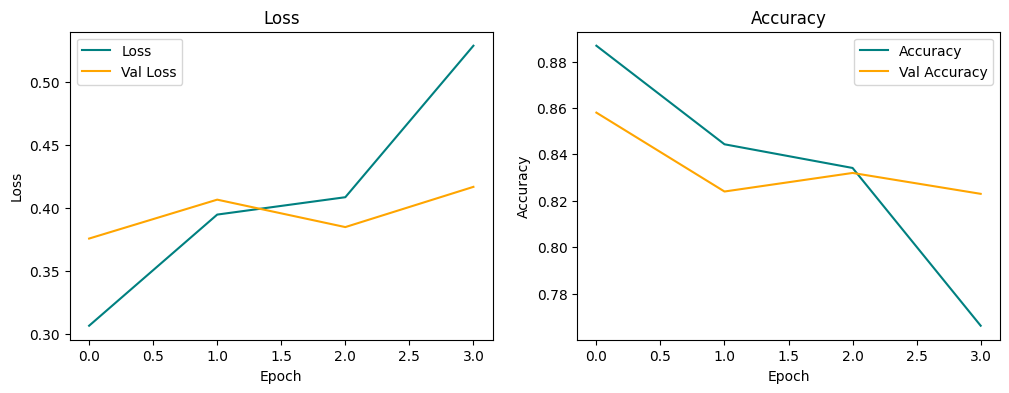

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training.history['loss'], label='Loss', color='teal')
plt.plot(training.history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training.history['accuracy'], label='Accuracy', color='teal')
plt.plot(training.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# Test and Evaluation

Total samples: 1000 | Positives (true): 500 | Negatives (true): 500
ROC-AUC: 0.9238
PR-AUC : 0.9098

Best threshold (max F1): 0.43 | Best F1: 0.8645
Threshold for recall >= 0.95: 0.2948 | F1 at this threshold: 0.8275

Chosen threshold used for confusion matrix: 0.4300
Saved: skinai_config.json

Confusion Matrix:
[[426  74]
 [ 63 437]]
True Positive (TP): 437
False Positive (FP): 74
True Negative (TN): 426
False Negative (FN): 63

Classification Report:
              precision    recall  f1-score   support

           0     0.8712    0.8520    0.8615       500
           1     0.8552    0.8740    0.8645       500

    accuracy                         0.8630      1000
   macro avg     0.8632    0.8630    0.8630      1000
weighted avg     0.8632    0.8630    0.8630      1000



<Figure size 800x800 with 0 Axes>

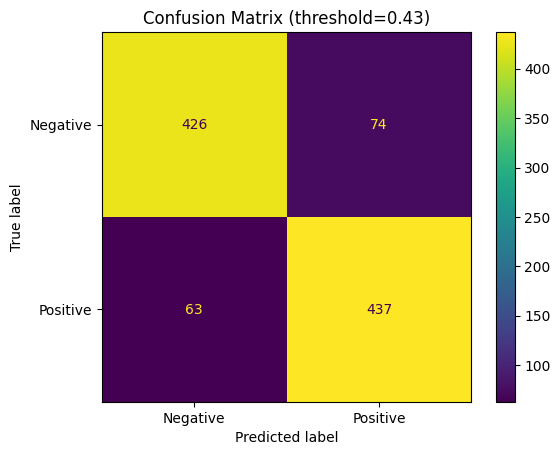

<Figure size 800x800 with 0 Axes>

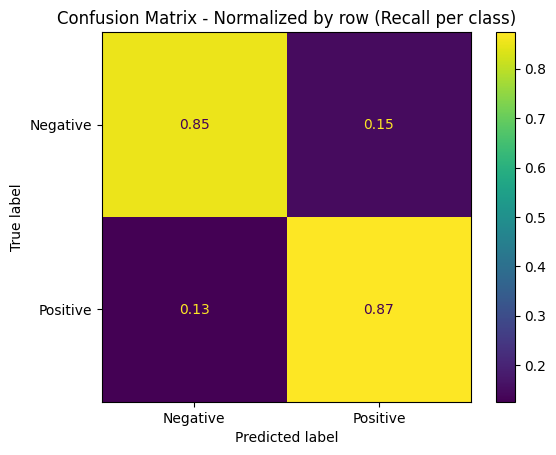

<Figure size 800x800 with 0 Axes>

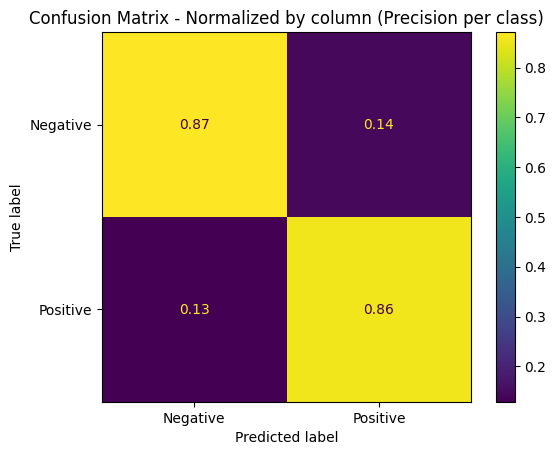

<Figure size 800x500 with 0 Axes>

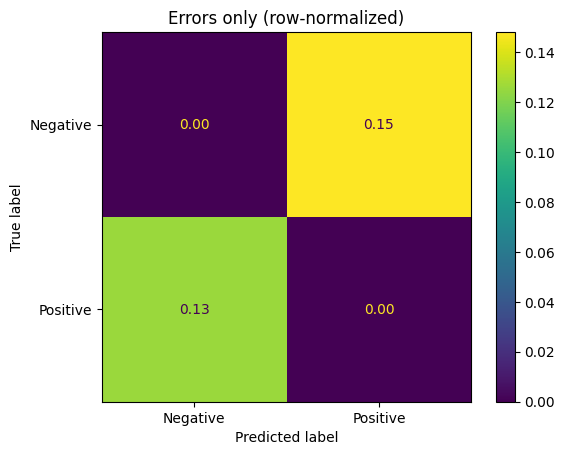

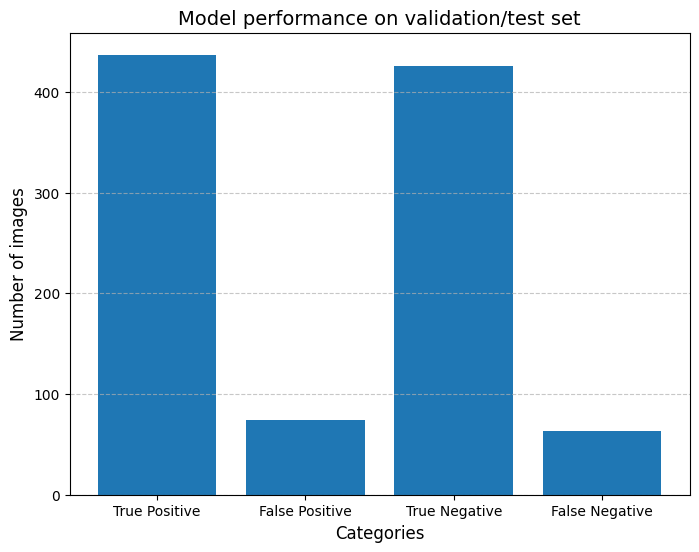


Predicted positives: 511 / 1000


In [13]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    f1_score,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve
)

y_true = []
probas = []

for X, y in val_ds:
    p = model.predict(X, verbose=0).flatten()
    probas.extend(p)
    y_true.extend(y.numpy())

y_true = np.array(y_true).astype(int)
probas = np.array(probas).astype(float)

print(f"Total samples: {len(y_true)} | Positives (true): {np.sum(y_true)} | Negatives (true): {len(y_true)-np.sum(y_true)}")

roc_auc = roc_auc_score(y_true, probas)
pr_auc = average_precision_score(y_true, probas)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC : {pr_auc:.4f}")

thresholds = np.linspace(0.01, 0.99, 99)
best_t, best_f1 = 0.5, -1

for t in thresholds:
    preds = (probas >= t).astype(int)
    f1 = f1_score(y_true, preds)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print(f"\nBest threshold (max F1): {best_t:.2f} | Best F1: {best_f1:.4f}")

target_recall = 0.95
prec, rec, thr = precision_recall_curve(y_true, probas)

valid = np.where(rec[:-1] >= target_recall)[0]
t_recall = thr[valid[-1]] if len(valid) > 0 else None

if t_recall is not None:
    preds_recall = (probas >= t_recall).astype(int)
    f1_recall = f1_score(y_true, preds_recall)
    print(f"Threshold for recall >= {target_recall:.2f}: {t_recall:.4f} | F1 at this threshold: {f1_recall:.4f}")
else:
    print(f"No threshold found achieving recall >= {target_recall:.2f} (try lowering target_recall).")

chosen_threshold = best_t
# chosen_threshold = t_recall if t_recall is not None else best_t

print(f"\nChosen threshold used for confusion matrix: {chosen_threshold:.4f}")

export_config = {
  "image_size": list(IMAGE_SIZE),
  "labels": {"0": "benign", "1": "malignant"},
  "output": "sigmoid",
  "normalization": "x/255.0",
  "chosen_threshold": float(chosen_threshold)
}

with open("/content/drive/MyDrive/SkinAI/models/skinai_config.json", "w") as f:
    json.dump(export_config, f, indent=2)

print("Saved: skinai_config.json")

y_pred = (probas >= chosen_threshold).astype(int)

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:\n{cm}")
print(f"True Positive (TP): {tp}")
print(f"False Positive (FP): {fp}")
print(f"True Negative (TN): {tn}")
print(f"False Negative (FN): {fn}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="viridis", values_format="d")
plt.title(f"Confusion Matrix (threshold={chosen_threshold:.2f})")
plt.show()

cm_normalized_row = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(8, 8))
disp_row = ConfusionMatrixDisplay(confusion_matrix=cm_normalized_row, display_labels=["Negative", "Positive"])
disp_row.plot(cmap="viridis", values_format=".2f")
plt.title("Confusion Matrix - Normalized by row (Recall per class)")
plt.show()

col_sums = cm.sum(axis=0, keepdims=True)
cm_normalized_col = np.divide(cm.astype(float), col_sums, where=col_sums!=0)
plt.figure(figsize=(8, 8))
disp_col = ConfusionMatrixDisplay(confusion_matrix=cm_normalized_col, display_labels=["Negative", "Positive"])
disp_col.plot(cmap="viridis", values_format=".2f")
plt.title("Confusion Matrix - Normalized by column (Precision per class)")
plt.show()

cm_errors_row = cm_normalized_row.copy()
np.fill_diagonal(cm_errors_row, 0)

plt.figure(figsize=(8, 5))
disp_err_row = ConfusionMatrixDisplay(confusion_matrix=cm_errors_row, display_labels=["Negative", "Positive"])
disp_err_row.plot(cmap="viridis", values_format=".2f")
plt.title("Errors only (row-normalized)")
plt.show()

categories = ['True Positive', 'False Positive', 'True Negative', 'False Negative']
values = [tp, fp, tn, fn]

plt.figure(figsize=(8, 6))
plt.bar(categories, values)
plt.title('Model performance on validation/test set', fontsize=14)
plt.ylabel('Number of images', fontsize=12)
plt.xlabel('Categories', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"\nPredicted positives: {np.sum(y_pred)} / {len(y_pred)}")

